In [1]:
#Importing the libraries
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nlp
import random
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import tweepy
from tweepy import OAuthHandler
import string
from textblob import TextBlob
import cv2
import urllib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
from collections import Counter
import datetime

import warnings
warnings.filterwarnings('ignore')

2023-01-20 01:49:53.356742: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 01:49:53.692483: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-20 01:49:53.692513: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-20 01:49:54.835566: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data = pd.read_csv('https://media.githubusercontent.com/media/deephaven/examples/main/Sentiment/csv/sentiment.csv')
data = data[['text','sentiment']]
data

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
...,...,...
13866,RT @cappy_yarbrough: Love to see men who will ...,Negative
13867,RT @georgehenryw: Who thought Huckabee exceede...,Positive
13868,"RT @Lrihendry: #TedCruz As President, I will a...",Positive
13869,RT @JRehling: #GOPDebate Donald Trump says tha...,Negative


In [3]:
pos_cnt, neg_cnt, neu_cnt = 0, 0, 0
for i in data['sentiment']:
    if i == 'Positive':
        pos_cnt += 1
    elif i == 'Negative':
        neg_cnt += 1
    else:
        neu_cnt += 1
print("number of positive data:", '{:.3g}'.format(pos_cnt / len(data) * 100), "%")
print("number of negative data:", '{:.3g}'.format(neg_cnt / len(data) * 100), "%")
print("number of neutral data:", '{:.3g}'.format(neu_cnt / len(data) * 100), "%")

number of positive data: 16.1 %
number of negative data: 61.2 %
number of neutral data: 22.7 %


In [4]:
#use Tokenizer to vectorize and convert text into Sequences

data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)



4472
16986


In [5]:
#Embedding
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

2023-01-20 01:50:21.722743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/romina/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-01-20 01:50:21.722987: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-20 01:50:21.723010: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (romina): /proc/driver/nvidia/version does not exist
2023-01-20 01:50:21.723755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 28, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [68]:

Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


(9293, 28) (9293, 3)
(4578, 28) (4578, 3)


In [58]:
#train 
batch_size = 32
model.fit(X_train, Y_train, epochs = 50, batch_size=batch_size, verbose = 3)

Epoch 1/50
225/225 - 7s - loss: 0.4185 - accuracy: 0.8254 - 7s/epoch - 33ms/step
Epoch 2/50
225/225 - 6s - loss: 0.2979 - accuracy: 0.8752 - 6s/epoch - 26ms/step
Epoch 3/50
225/225 - 6s - loss: 0.2531 - accuracy: 0.8986 - 6s/epoch - 28ms/step
Epoch 4/50
225/225 - 6s - loss: 0.2115 - accuracy: 0.9119 - 6s/epoch - 27ms/step
Epoch 5/50
225/225 - 6s - loss: 0.1790 - accuracy: 0.9284 - 6s/epoch - 27ms/step
Epoch 6/50
225/225 - 6s - loss: 0.1544 - accuracy: 0.9356 - 6s/epoch - 27ms/step
Epoch 7/50
225/225 - 6s - loss: 0.1332 - accuracy: 0.9449 - 6s/epoch - 27ms/step
Epoch 8/50
225/225 - 6s - loss: 0.1153 - accuracy: 0.9524 - 6s/epoch - 27ms/step
Epoch 9/50
225/225 - 6s - loss: 0.1042 - accuracy: 0.9549 - 6s/epoch - 27ms/step
Epoch 10/50
225/225 - 6s - loss: 0.0938 - accuracy: 0.9605 - 6s/epoch - 28ms/step
Epoch 11/50
225/225 - 6s - loss: 0.0831 - accuracy: 0.9649 - 6s/epoch - 27ms/step
Epoch 12/50
225/225 - 6s - loss: 0.0748 - accuracy: 0.9687 - 6s/epoch - 27ms/step
Epoch 13/50
225/225 - 6s 

In [59]:
model.save("model.h5")

In [60]:
#Extracting a validation set, and measuring score and accuracy
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 3, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.24
acc: 0.82


In [61]:
#measuring the number of correct guesses
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 3)[0]

    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")
print("total_acc", (pos_correct + neg_correct) / (pos_cnt + neg_cnt) * 100, "%")

pos_acc 60.517799352750814 %
neg_acc 87.6574307304786 %
total_acc 82.06666666666666 %


In [18]:
class TwitterSentClass():
    def __init__(self):
        API_key = ''
        API_secret = ''
        access_token = ''
        access_token_secret = ''
        try:
            self.auth = OAuthHandler(API_key, 
                                     API_secret)
            self.auth.set_access_token(access_token,
                                       access_token_secret)
            self.api = tweepy.API(self.auth)
            print('Authenticated')
        except:
            print("Sorry! Error in authentication!")
 
    def cleaning_process(self, tweet):
        text = tweet.lower()
        text = re.sub('\[.*?\]', '', tweet)
        text = re.sub('https?://\S+|www\.\S+', '', text)
        text = re.sub('<.*?>+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\n', '', text)
        text = re.sub('\w*\d\w*', '', text)
        return text
 
    def get_sentiment(self, tweet):
        lst = tweet.split()
        tweet = tokenizer.texts_to_sequences(lst)
        tweet = pad_sequences(tweet)
        tweet = [[int(i[0]) for i in tweet]]
        analysis = model.predict([tweet],batch_size=1,verbose = 3)[0]
        if np.argmax(analysis) > 0:
            return 'positive'
        elif np.argmax(analysis) == 0:
            return 'neutral'
        else:
            return 'negative'
 
    def get_tweets(self, query, count=1000):
        tweets = []
        try:
            fetched_tweets = self.api.search_tweets(q = query, count = count)
            for tweet in fetched_tweets:
                parsed_tweet = {}
                parsed_tweet['text'] = tweet.text
                parsed_tweet['sentiment'] =self.get_sentiment(tweet.text)
                if tweet.retweet_count > 0:
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)
            return tweets
 
        except tweepy.errors.TweepyException as e:
            print("Error : " + str(e))

In [19]:
def load_mask(mask_url):
    with urllib.request.urlopen(mask_url) as resp:
        mask = np.asarray(bytearray(resp.read()), dtype="uint8")
        mask = cv2.imdecode(mask, cv2.IMREAD_COLOR)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
    return mask

In [20]:
def plot_word_cloud(df_tweet, colormap, category):
    new_mask = cv2.imread('Twitter-featured.png')

    wordcloud = WordCloud(
        background_color="white",
        colormap=colormap,
        mask=new_mask,
        random_state=42,
        max_font_size=50,
        max_words=1000,
    )

    text = ''.join(df_tweet[1:])


    wordcloud.generate(text) 

    image_colors = ImageColorGenerator(new_mask)

    plt.figure(figsize=(16, 8))
    plt.title('Word cloud for {} tweets'.format(category))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# #TedCruz

In [44]:
arr_pred = []
arr_pos_txt = []
arr_neg_txt = []
api = TwitterSentClass()
t = '#TedCruz'
tweets = api.get_tweets(query = t, count = 2000)

pos_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
pos = "Positive tweets percentage: {} %".format(100*len(pos_tweets)/len(tweets))

neg_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
neg="Negative tweets percentage: {}%".format(100*len(neg_tweets)/len(tweets))                
arr_pred.append(pos)
arr_pred.append(neg)

# storing first 5 positive tweets
arr_pos_txt.append("Positive tweets:")
for tweet in pos_tweets[:5]:
    arr_pos_txt.append(tweet['text'])

# storing first 5 negative tweets
arr_neg_txt.append("Negative tweets:")
for tweet in neg_tweets[:5]:
    arr_neg_txt.append(tweet['text'])


Authenticated


In [45]:
def plot_most_common_terms(df):
    word_list = []
    
    for i, j in pd.DataFrame(df).iterrows():
        for word in j['text'].split():
            if len(word) > 3 and 'ted' not in word.lower():
                word_list.append(word)
        
    count_dict = Counter(word_list)
    most_common_words_df = pd.DataFrame(count_dict.most_common(20), columns=['word', 'count'])
    
    fig = px.histogram(most_common_words_df,
                       x='word', 
                       y='count',
                       title='Most common terms used in #TedCruz\'s tweets.',
                       color_discrete_sequence=['#D8E46B'] )
    fig.show()
plot_most_common_terms(tweets)

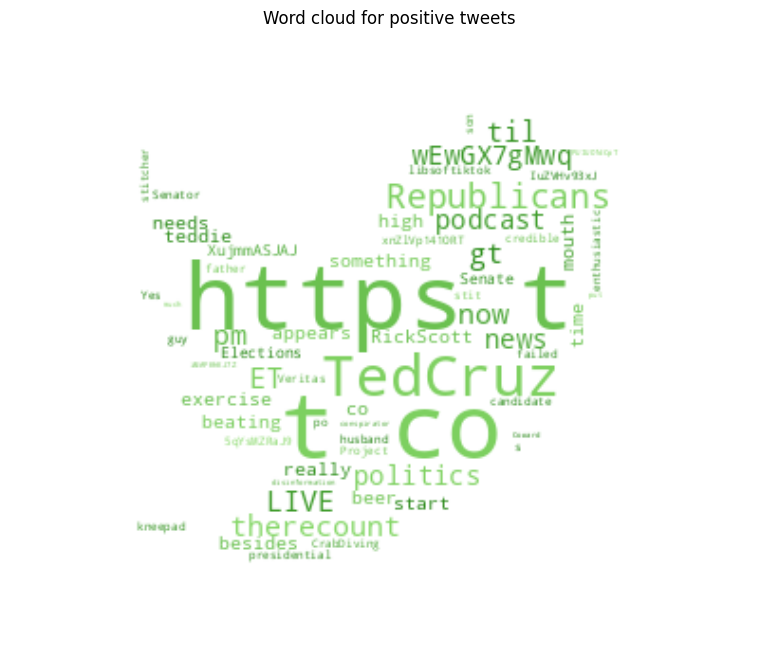

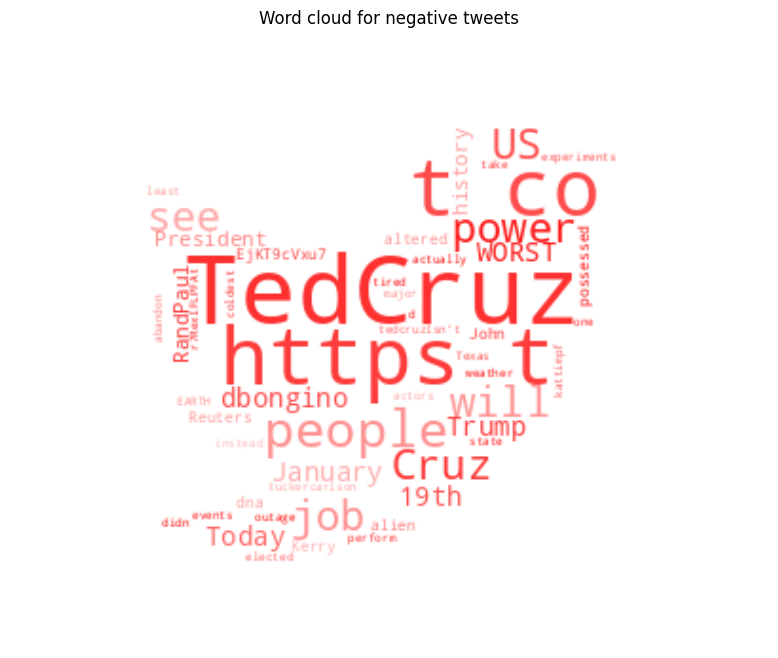

In [46]:
colors_pos = ["#88D969", "#1D800E"]
cmap_pos = LinearSegmentedColormap.from_list("mycmapos", colors_pos)

colors_neg = ["#ffbaba", "#ff0000"]
cmap_neg = LinearSegmentedColormap.from_list("mycmapos", colors_neg)

colors_neutral = ["#ffecb3", "#ffca28"]
cmap_neutral = LinearSegmentedColormap.from_list("mycmapos", colors_neutral)

pos_cloud = []
for tweet in pos_tweets:
    pos_cloud.append(tweet['text'])

neg_cloud = []
for tweet in neg_tweets:
    neg_cloud.append(tweet['text'])

plot_word_cloud(pos_cloud, cmap_pos, 'positive')
plot_word_cloud(neg_cloud, cmap_neg, 'negative')

In [47]:
print("percentage of positive tweets: ", '{0:.3g}'.format(len(pos_cloud) / (len(tweets)) * 100), "%")
print("percentage of negative tweets: ", '{0:.3g}'.format(len(neg_tweets) / (len(tweets)) * 100), "%")

percentage of positive tweets:  14.8 %
percentage of negative tweets:  27.8 %


In [48]:
print(tweets[:20])

[{'text': "@tedcruz You should read the Bible, Cruz. You're doing the opposite of what Jesus commanded with regards to refugees.\n#tedcruz", 'sentiment': 'neutral'}, {'text': "@SenTedCruz Never trust criminals on crime. #TedCruz That's why FOX is a propaganda network #FoxIsNotNews @FBI… https://t.co/JNJW0ei1nI", 'sentiment': 'negative'}, {'text': 'RT @sprzyslp: @Tentoads4truth @LongAsUCan2 @dianesbaker1 @MelissaJPeltier @bywillpollock @stonewrapper @3015nyac @DavidManOnFire @sisu_sani…', 'sentiment': 'neutral'}, {'text': '@AdamSchiff .#Boebert has a long rap sheet. She was apparently a #hooker who bent over for a #Koch family member wh… https://t.co/WOtVttmwcY', 'sentiment': 'neutral'}, {'text': '@dbongino Today is January 19th, 2023 and #Trump was the WORST President in US history. #TedCruz #RandPaul… https://t.co/EjKT9cVxu7', 'sentiment': 'negative'}, {'text': 'Psalms Prayer: Related to Lord Jesus, Saints and the Wicked: https://t.co/3LU184wNN4\n-\n#God #Christians #Prayer… https://t

In [51]:
lebeled_tweets = [{'text': "@tedcruz You should read the Bible, Cruz. You're doing the opposite of what Jesus commanded with regards to refugees.\n#tedcruz", 'sentiment': 'negative'}, {'text': "@SenTedCruz Never trust criminals on crime. #TedCruz That's why FOX is a propaganda network #FoxIsNotNews @FBI… https://t.co/JNJW0ei1nI", 'sentiment': 'negative'}, {'text': 'RT @sprzyslp: @Tentoads4truth @LongAsUCan2 @dianesbaker1 @MelissaJPeltier @bywillpollock @stonewrapper @3015nyac @DavidManOnFire @sisu_sani…', 'sentiment': 'neutral'}, {'text': '@AdamSchiff .#Boebert has a long rap sheet. She was apparently a #hooker who bent over for a #Koch family member wh… https://t.co/WOtVttmwcY', 'sentiment': 'negative'}, {'text': '@dbongino Today is January 19th, 2023 and #Trump was the WORST President in US history. #TedCruz #RandPaul… https://t.co/EjKT9cVxu7', 'sentiment': 'negative'}, {'text': 'Psalms Prayer: Related to Lord Jesus, Saints and the Wicked: https://t.co/3LU184wNN4\n-\n#God #Christians #Prayer… https://t.co/boLz7NTewI', 'sentiment': 'neutral'}, {'text': '@Reuters John Kerry is alien possessed and altered dna experiments Only people can be elected for EARTH.\n#kattimpf\n#tuckercarlson\n#tedcruz', 'sentiment': 'negative'}, {'text': '@therecount Maybe Rafel need some parental training…. Just saying #TedCruz', 'sentiment': 'negative'}, {'text': 'RT @AwesomeTalkTV: Check out this video "Highlight: Rick\'s Tweets to Ted Cruz from Awesome Talk! S16, Ep5!" #TedCruz #TedCruzLies #PodcastA…', 'sentiment': 'positive'}, {'text': "Isn't #Texas tired of people who take a job to perform, like actors, instead of to actually do the job?\n\n#TedCruz d… https://t.co/r7RexIFLPF", 'sentiment': 'negative'}, {'text': 'At least he didn’t abandon his state during a major power outage during one of the coldest weather events ever!… https://t.co/7n8PCNBL4R', 'sentiment': 'negative'}, {'text': '@mitchellvii U R an #AntiTrump &amp; #ProDesantisRINO Remember nobody cares about #TedCruz &amp; the same will happen to… https://t.co/KOUkylSek2', 'sentiment': 'negative'}, {'text': '@tedcruz \nHow does it feel to know that no one will ever have any respect for you? Was the political "power" you th… https://t.co/AedCpHAazt', 'sentiment': 'negative'}, {'text': 'RT @tnblueamy: Who did this??😂😂😂😂 #HershelWalker #LindseyGraham #TedCruz https://t.co/JfJjpr5ibA', 'sentiment': 'neutral'}, {'text': '@MrScottLads #TedCruz is a Traitor to his family and country. https://t.co/mOY4ru0MhA', 'sentiment': 'negative'}, {'text': '@cat_barnes30 5, 6, 9... no one can out debate #TedCruz', 'sentiment': 'neutral'}, {'text': '@therecount #PeteButtigieg takes care his Family, #TedCruz is quite the opposite', 'sentiment': 'neutral'}, {'text': 'Republicans are cowards. They demonize small groups,minorities, "the other" because those people have no power, mil… https://t.co/DMpHDwDutO', 'sentiment': 'negative'}, {'text': '@SenTedCruz #Anonymous #TedCruz #RedFlag #SaveDemocracy #USA https://t.co/3tggDjawia', 'sentiment': 'neutral'}, {'text': "RT @Fearnl1Fearnley: @tedcruz It is staggering that someone as vile and m0ronic like you are being paid by American tax payers. You're corr…", 'sentiment': 'neutral'}]

In [52]:
cnt = 0
for i in range(20):
    if tweets[i]['sentiment'] == lebeled_tweets[i]['sentiment']:
        cnt += 1
print("accuracy for the #FIFAWorldCup first 20 tweets:", cnt / 20 * 100, "%")

accuracy for the #FIFAWorldCup first 20 tweets: 70.0 %


# #FIFAWorldCup

In [35]:
arr_pred = []
arr_pos_txt = []
arr_neg_txt = []
api = TwitterSentClass()
t = '#FIFAWorldCup'
tweets = api.get_tweets(query = t, count = 2000)

pos_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
pos = "Positive tweets percentage: {} %".format(100*len(pos_tweets)/len(tweets))

neg_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
neg="Negative tweets percentage: {}%".format(100*len(neg_tweets)/len(tweets))                
arr_pred.append(pos)
arr_pred.append(neg)

# storing first 5 positive tweets
arr_pos_txt.append("Positive tweets:")
for tweet in pos_tweets[:5]:
    arr_pos_txt.append(tweet['text'])

# storing first 5 negative tweets
arr_neg_txt.append("Negative tweets:")
for tweet in neg_tweets[:5]:
    arr_neg_txt.append(tweet['text'])


Authenticated


In [36]:
def plot_most_common_terms(df):
    word_list = []
    
    for i, j in pd.DataFrame(df).iterrows():
        for word in j['text'].split():
            if len(word) > 3 and 'ted' not in word.lower():
                word_list.append(word)
        
    count_dict = Counter(word_list)
    most_common_words_df = pd.DataFrame(count_dict.most_common(20), columns=['word', 'count'])
    
    fig = px.histogram(most_common_words_df,
                       x='word', 
                       y='count',
                       title='Most common terms used in #FIFAWorldCup\'s tweets.',
                       color_discrete_sequence=['#D8E46B'] )
    fig.show()
plot_most_common_terms(tweets)

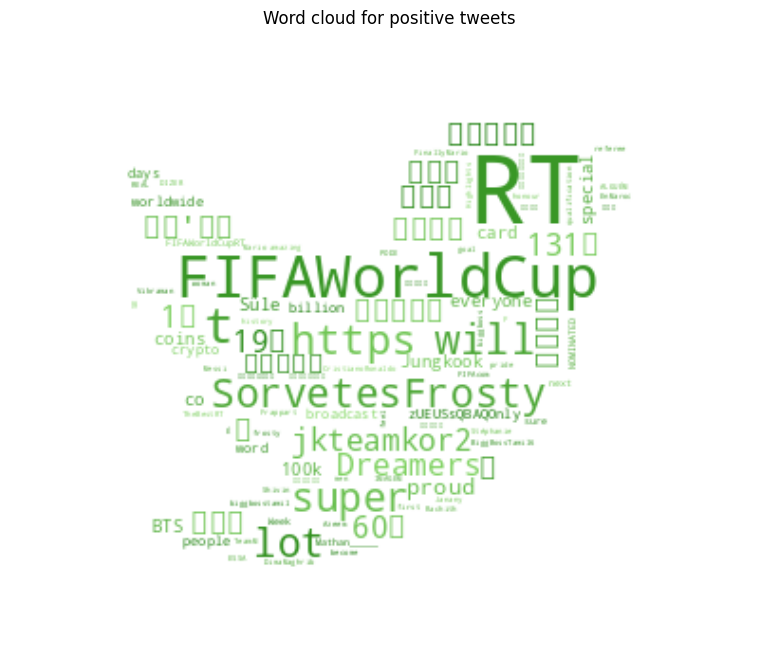

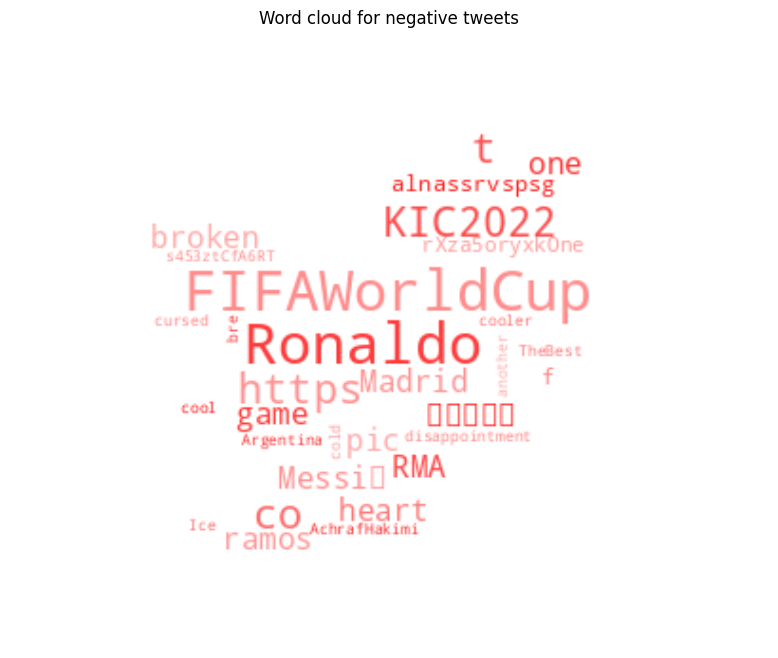

In [37]:
colors_pos = ["#88D969", "#1D800E"]
cmap_pos = LinearSegmentedColormap.from_list("mycmapos", colors_pos)

colors_neg = ["#ffbaba", "#ff0000"]
cmap_neg = LinearSegmentedColormap.from_list("mycmapos", colors_neg)

colors_neutral = ["#ffecb3", "#ffca28"]
cmap_neutral = LinearSegmentedColormap.from_list("mycmapos", colors_neutral)

pos_cloud = []
for tweet in pos_tweets:
    pos_cloud.append(tweet['text'])

neg_cloud = []
for tweet in neg_tweets:
    neg_cloud.append(tweet['text'])

plot_word_cloud(pos_cloud, cmap_pos, 'positive')
plot_word_cloud(neg_cloud, cmap_neg, 'negative')

In [38]:
print("percentage of positive tweets: ", '{0:.3g}'.format(len(pos_cloud) / (len(tweets)) * 100), "%")
print("percentage of negative tweets: ", '{0:.3g}'.format(len(neg_tweets) / (len(tweets)) * 100), "%")

percentage of positive tweets:  23.3 %
percentage of negative tweets:  11.6 %


In [39]:
print(tweets[:20])

[{'text': "RT @sohairarif97: Much love between these fans of the Argentina &amp; Saudi Arabia during today's match in Lusail Stadium.\n \n#FIFAWorldCup\n#ARG…", 'sentiment': 'positive'}, {'text': 'RT @FIFAWorldCup: One disappointment after another... until 2022 🏆🇦🇷\n\nWas Argentina cursed after the 1986 #FIFAWorldCup? Did they break the…', 'sentiment': 'negative'}, {'text': "RT @jkteamkor2: 1월 19일\n정국의 Dreamers 가 '스포티파이 글로벌 데일리 차트'에서 131위(-8)를 기록하며 60일 차트인하고 있습니다.\n축하합니다 🎉 🎉 🎉 \n\nWe're so proud of #Jungkook of @BTS…", 'sentiment': 'positive'}, {'text': '🥺 #アリヴァラ #game #FIFAWorldCup #KIC2022 #KIC2022?', 'sentiment': 'negative'}, {'text': "there are Süle 85 not under 100k coins💸but the 88 special card is there ?? It's the same with everyone, where has t… https://t.co/zUEUSsQBAQ", 'sentiment': 'positive'}, {'text': "#Ronaldo\nMy Madrid's broken heart ❤️in one pic 💔 #RMA #ronaldo #ramos\n\n#ronaldo #Messi𓃵 #Ronaldo #alnassrvspsg\n\nA f… https://t.co/rXza5oryxk", 'sentiment': 'negative'}, 

In [42]:
labeled_tweets = [{'text': "RT @sohairarif97: Much love between these fans of the Argentina &amp; Saudi Arabia during today's match in Lusail Stadium.\n \n#FIFAWorldCup\n#ARG…", 'sentiment': 'positive'}, {'text': 'RT @FIFAWorldCup: One disappointment after another... until 2022 🏆🇦🇷\n\nWas Argentina cursed after the 1986 #FIFAWorldCup? Did they break the…', 'sentiment': 'negative'}, {'text': "RT @jkteamkor2: 1월 19일\n정국의 Dreamers 가 '스포티파이 글로벌 데일리 차트'에서 131위(-8)를 기록하며 60일 차트인하고 있습니다.\n축하합니다 🎉 🎉 🎉 \n\nWe're so proud of #Jungkook of @BTS…", 'sentiment': 'positive'}, {'text': '🥺 #アリヴァラ #game #FIFAWorldCup #KIC2022 #KIC2022?', 'sentiment': 'neutral'}, {'text': "there are Süle 85 not under 100k coins💸but the 88 special card is there ?? It's the same with everyone, where has t… https://t.co/zUEUSsQBAQ", 'sentiment': 'negative'}, {'text': "#Ronaldo\nMy Madrid's broken heart ❤️in one pic 💔 #RMA #ronaldo #ramos\n\n#ronaldo #Messi𓃵 #Ronaldo #alnassrvspsg\n\nA f… https://t.co/rXza5oryxk", 'sentiment': 'negative'}, {'text': 'RT @SharkiesBay: On the next level🏆\n\nHow’s it going shark fam?🦈\n\nDo you like soccer?⚽️\n\n#NFT #FIFAWorldCup #Qatar2022 https://t.co/AR2HsnVV…', 'sentiment': 'neutral'}, {'text': 'Only 2️⃣ more days until the word “crypto” is broadcast to over 5 billion people worldwide. 👀 #FIFAWorldCup', 'sentiment': 'positive'}, {'text': 'RT @numberweb: 「PK戦に強くなる」ことは可能なのか？ 岡崎慎司がW杯を見て感じた“背負いすぎ”問題「日本人の美徳とも言えるんだろうけれど…」（寺野典子）\n#サッカー日本代表 #SAMURAIBLUE #FIFAWorldCup #Qatar2022 #岡崎慎司…', 'sentiment': 'neutral'}, {'text': 'RT @Mathan_____: Who will NOMINATED sure for next Week?\n\n#BiggBossTamil6 #biggboss #biggbosstamil #Azeem #Vikraman #Janany #Shivin #Rachith…', 'sentiment': 'neutral'}, {'text': 'RT @numberweb: 「鎌田大地がやるのも面白い」岡崎慎司が語った日本代表“これからのキャプテン像”とは？「ベテランにやってほしくない」と考える理由（寺野典子）\n#サッカー日本代表 #SAMURAIBLUE #FIFAWorldCup #Qatar2022 #岡崎慎司…', 'sentiment': 'neutral'}, {'text': 'RT @numberweb: 岡崎慎司「日本人の特性という武器だけではダメなんです」欧州で遠回りをしないために伝えたい“自己確立”の大切さと“部活の可能性”（寺野典子）\n#サッカー日本代表 #SAMURAIBLUE #FIFAWorldCup #Qatar2022 #岡崎慎司…', 'sentiment': 'neutral'}, {'text': 'RT @FIFAcom: One month on from #Qatar2022 🏆🔢\n\nFrom 172 goals to 420,000 volunteer applications, we take a look back at the record-breaking…', 'sentiment': 'neutral'}, {'text': 'One disappointment after another... until 2022 🏆🇦🇷\n\nWas Argentina cursed after the 1986 #FIFAWorldCup? Did they bre… https://t.co/s453ztCfA6', 'sentiment': 'negative'}, {'text': 'One our faves 🔥 Republic of Ireland 95/96 Home Shirt NOW ONLY £74.99! \n\nhttps://t.co/WckDeJlLkm\n\n#ireland #worldcup… https://t.co/YK7Obs0ULG', 'sentiment': 'neutral'}, {'text': 'RT @cryptocom: This time last month ⚽️👌 #FIFAWorldCup https://t.co/2qMio9qdR4', 'sentiment': 'neutral'}, {'text': 'RT @FIFAWorldCup: The next chapter begins for @cristiano tonight 💫\n\nWill he have the King Fahd Stadium sounding like this? 🗣️🔊\n\n#FIFAWorldC…', 'sentiment': 'positive'}, {'text': 'RT @SorvetesFrosty: ALGUÉM PODE ME DIZER SE ESSA IMAGEM É REAL??? #Messi #FIFAWorldCup #CristianoRonaldo #frosty #sorvetesfrosty https://t.…', 'sentiment': 'positive'}, {'text': 'RT @Ismaindahouse: Ace Mbappé. 🇫🇷\n\nInspirado en la figura que sacaron hace poco 💯\n\n#FIFAWorldCup #ONEPIECE\xa0  #ワンピース  #ルフィ https://t.co/EPOJ…', 'sentiment': 'neutral'}, {'text': 'RT @atooof33: ل #الاعلاميين و #المصورين \nانطلاق عملية منح تصاريح ممثلي وسائل الإعلام لتغطية بطولة #كأس_العالم_للأندية #كأس_العالم_للأندية_F…', 'sentiment': 'neutral'}]

In [43]:
cnt = 0
for i in range(20):
    if tweets[i]['sentiment'] == labeled_tweets[i]['sentiment']:
        cnt += 1
print("accuracy for the #FIFAWorldCup first 20 tweets:", cnt / 20 * 100, "%")

accuracy for the #FIFAWorldCup first 20 tweets: 80.0 %
